In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from tabulate import tabulate
import scipy.io
import warnings
warnings.filterwarnings("ignore")

# Task 1: Poisson neuron

In [2]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [12, 3]

## Section A

_Deviations from Poisson neuron model:_

_The use of logarithmic scale autocorrelation:_

Bin number is related to log of temporal interval. int means integer truncation and alpha constant that determines width ratio of successive bins.

(1) bin number: $n(i, j) = int[\frac{1}{\alpha}log_{10}(t_j - t_i)],\quad j > i$

raw count histogram calculated by summing every pair of spikes in recording for intervals in the range of $1 \le \Delta t \le 1000$ ms.

(2) raw count histogram: $C(n) = \sum_{i=1}^{N-1}\sum_{j=i+1}^{N}n(i, j)$

normalisation of histogram by dividing by bin width $10^{\alpha (n+1)} - 10^{\alpha n}$ and total number of spikes squared $N^2$ and multiplying by duration of recording $T$. Reason is raw bin count is expected to linearly increase with $N^2$ and decrease with $T$.

(3) normalised histogram: $A(n) = \frac{T}{N^2}\frac{C(n)}{10^{\alpha (n+1)} - 10^{\alpha n}}$

1 in every bin (flat histogram) is Poisson limit. n times more than 1 means n times more spikes than expected from random firing.

A possible critique could involve that this approach is inappropriate for low firing rates, that is, low number of spikes, even though below 0.1Hz usefuleness to test is questionable (they talk about this in discussion page 6518)

_Comparison with Poisson neuron:_

autocorrelation function for Poisson neuron is expected to return flat histogram constant 1, whereas most of the spontaneuous activation in neurons from the study show variability and oscillations with some peaks and usually variance greater than mean. 

(4) goodness of fit: $g = \frac{1}{K - k + 1}\sum_{n=k}^{K}\frac{(A_n - 1)^2}{\sigma_{n}^{2}}$

## Section B

In [6]:
freq = 1e-3
T = int(90 / freq)
r0 = freq * 55
ref_t = 5
rec_t = 6
burst_t = 6

In [7]:
refractory_train = []
refractory_isis = []

for t in range(T):

    if len(refractory_train) == 0:
        r = r0
        seq = 6
    elif refractory_train[t - 1] == 1:
        refractory_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1

    if seq <= ref_t:
        r = 0
    else:
        r = r0 / rec_t * min(seq - ref_t, rec_t)
        
    spike = np.random.binomial(1, r)
    refractory_train.append(spike)

if refractory_train[0] != 1:
    refractory_isis = refractory_isis[1:]

if refractory_train[-1] != 1:
    refractory_isis = refractory_isis[:-1]

## Section C

In [8]:
burst_train = []
burst_isis = []

for t in range(T):

    if len(burst_train) == 0:
        seq = 0
    elif burst_train[t - 1] == 1:
        burst_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1

    if seq <= burst_t:
        r = r0 + 0.015 / (burst_t - 1) * seq
    else:
        r = r0
        
    spike = np.random.binomial(1, r)
    burst_train.append(spike)

if burst_train[0] != 1:
    burst_isis = burst_isis[1:]

if burst_train[-1] != 1:
    burst_isis = burst_isis[:-1]

## Section D

In [9]:
poisson_train = []
poisson_isis = []

for t in range(T):

    if len(poisson_train) == 0:
        seq = 0
    elif poisson_train[t - 1] == 1:
        poisson_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1
        
    r = r0
    spike = np.random.binomial(1, r)
    poisson_train.append(spike)

if poisson_train[0] != 1:
    poisson_isis = poisson_isis[1:]

if poisson_train[-1] != 1:
    poisson_isis = poisson_isis[:-1]

## Section E

Text(0, 0.5, 'Neural Spike [0/1]')

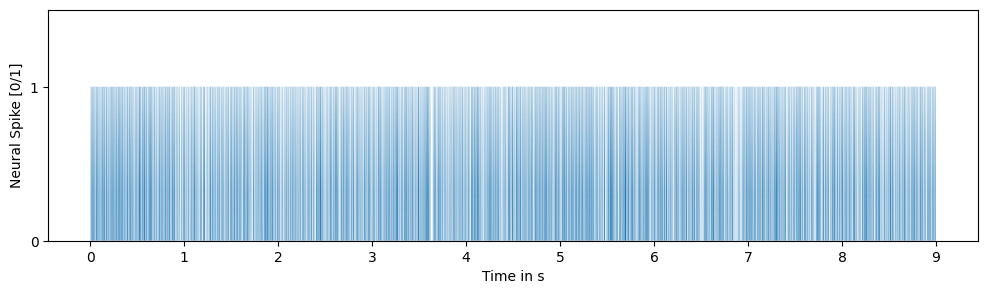

In [10]:
plt.plot(burst_train, linewidth=0.05)

plt.ylim([0, 1.5])
plt.xticks(np.arange(0, 10) * 1e4, labels=np.arange(0, 10))
plt.yticks([0, 1])

plt.xlabel("Time in s")
plt.ylabel("Neural Spike [0/1]")

Text(0, 0.5, 'Count')

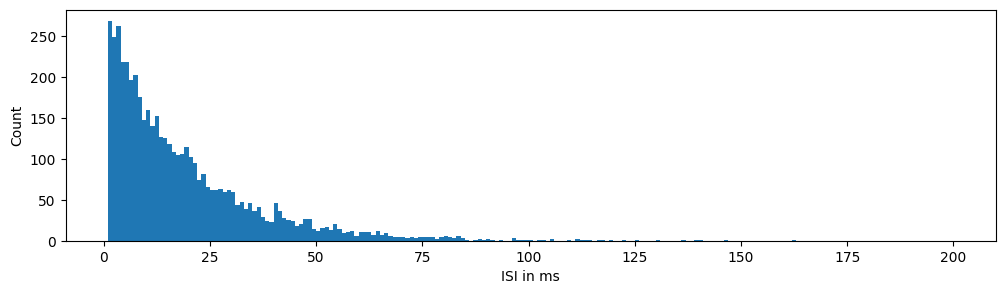

In [36]:
plt.hist(poisson_isis, bins=np.arange(1, 201))


Text(0, 0.5, 'Count')

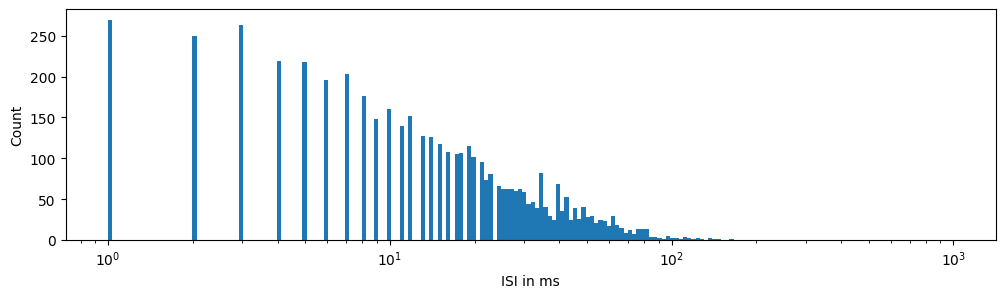

In [39]:
plt.hist(poisson_isis, bins=np.logspace(np.log10(1), np.log10(1000), 201))
plt.xscale("log")

plt.xlabel("ISI in ms")
plt.ylabel("Count")

Text(0, 0.5, 'Survivor(t)')

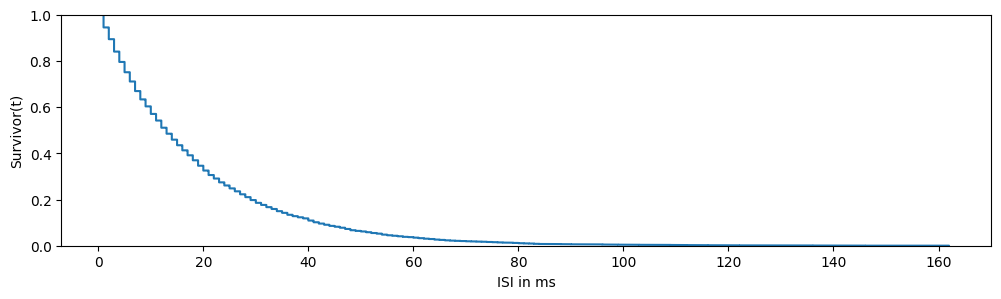

In [43]:
plt.ecdf(poisson_isis, complementary=True)

plt.xlabel("ISI in ms")
plt.ylabel("Survivor(t)")

# Task 2: Encoding: GLM, optimal kernel and STA

In [27]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [10, 3]

## Section A

In [2]:
sta = scipy.io.loadmat("GLM/STA.mat")
spikeTrain = sta["spikeTrain"].flatten()
stimSig = sta["stimSig"].flatten()

In [27]:
freq = 2000
period = 1 / freq

n = spikeTrain.shape[0]
time = n * period

intervals = np.arange(0, time, period)

NameError: name 'intervals' is not defined

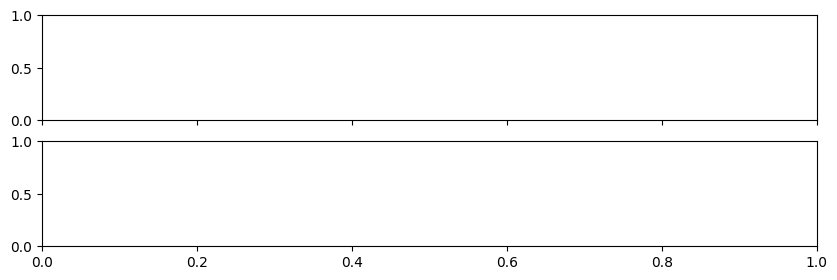

In [28]:
fig, axis = plt.subplots(2, sharex=True)

axis[0].plot(intervals, stimSig, c="b")
axis[1].plot(intervals, spikeTrain, c="r")

axis[1].set_ylim(0, 2)
axis[1].set_xlabel("Time in s")
axis[0].set_ylabel("Stimulus Amplitude in au")
axis[1].set_ylabel("Neural Spike")

plt.tight_layout()

In [36]:
window_size = 0.5
window = int(window_size * freq)
stimulus_list = []
indices = np.where(spikeTrain == 1)[0]

for idx in indices:

    stimulus = stimSig[idx - window:idx + window + 1]
    stimulus_list.append(stimulus)

stimulus_arr = np.concatenate(stimulus_list).reshape(len(stimulus_list), 2 * window + 1)
sta_means = np.mean(stimulus_arr, axis=0)
sta_stds = np.std(stimulus_arr, axis=0)

Text(0, 0.5, 'Stimulus Amplitude in au')

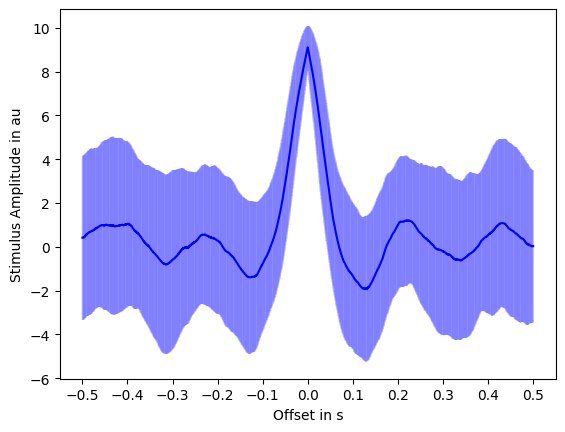

In [43]:
window_range = np.arange(-window_size, window_size + period, period)
xticks_range = np.arange(-window_size, window_size + 0.1, 0.1)

plt.errorbar(window_range, sta_means, yerr=sta_stds, elinewidth=0.1, c="b")

plt.xticks(xticks_range)
plt.xlabel("Offset in s")
plt.ylabel("Stimulus Amplitude in au")

Optimal frequency is around 500 s

In [20]:
np.sin(2 * np.pi * )

0.49975012493753124

## Section B

In [2]:
kernel = scipy.io.loadmat("GLM/kernel.mat")
stim = kernel["stim"]
resp = kernel["resp"]

In [40]:
freq = 1000
step = 1 / freq

samples = np.arange(0, 60, step)
train = np.mean(resp, axis=0)

In [23]:
# Define function for computing and plotting firing rates with sliding square window
def plot_square(train, samples, window_size, c, step=0.001, mode="same"):

    window = np.ones(int(window_size / step))
    window /= sum(window)

    firing_rates = np.convolve(train, window, mode) / step

    plt.plot(samples, firing_rates, c=c, label=window_size)

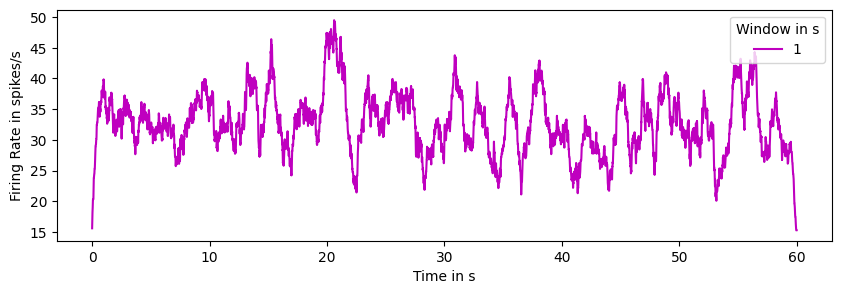

In [54]:
# Plot firing rates for different window sizes
#plot_square(train, samples, 0.3, "b")
#plot_square(train, samples, 0.5, "r")
#plot_square(train, samples, 0.7, "k")
plot_square(train, samples, 1, "m")
#plot_square(train, samples, 1.3, "y")

plt.xlabel("Time in s")
plt.ylabel("Firing Rate in spikes/s")
plt.legend(title="Window in s", loc="upper right")

# Task 3: PSTH and ROC

In [2]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [10, 4]

## Section A

In [3]:
# Import datasets
sound_times = pd.read_csv("PSTH/sound_times.csv", header=None).to_numpy()
lick_times = pd.read_csv("PSTH/lick_times.csv", header=None).to_numpy()
spike_trains = pd.read_csv("PSTH/spike_trains.csv", header=None).to_numpy()

In [13]:
# Define function to process spike train into based on stimulus array and trial window
def process_spike_trains(spike_trains, event_times, trial_window):

    trial_list = []
    event_idx = np.round(event_times * 1e3).astype(int)

    for i in range(spike_trains.shape[1]):
        
        if i in event_idx:

            trial = spike_trains[:, i + trial_window[0]:i + trial_window[1]]
            trial_list.append(trial)

    spike_arr = np.hstack(trial_list).reshape(4, len(trial_list), -1)
    psth_vals = 1000 * np.mean(spike_arr, axis=1)

    return spike_arr, psth_vals

# Define function to generate a raster plot given a trial window
def plot_raster(arr, trial_window, ax):

    spike_list = [np.where(arr[i, :])[0] for i in range(arr.shape[0])]

    ax.eventplot(spike_list, colors="k")
    ax.axvline(x=-trial_window[0], color="r", linestyle="--")

    ax.set_ylabel("Trial")

# Define function to generate a PSTH given a trial window
def plot_psth(psth_vals, trial_window, ax):
    
    trial_range = np.arange(trial_window[0], trial_window[1], 100) / 1000
    time_range = np.arange(0, trial_window[1] - trial_window[0])
    xticks_range = np.arange(0, trial_window[1] - trial_window[0], 100)

    ax.bar(time_range, psth_vals, color="k")
    ax.axvline(x=-trial_window[0], color="r", linestyle="--")

    ax.set_xticks(ticks=xticks_range, labels=trial_range)
    ax.set_xlabel("Offset in s")
    ax.set_ylabel("Firing Rate in spikes/s")

In [14]:
# Process spike train with window around sound event
trial_window = [-200, 1001]
spike_arr, psth_vals = process_spike_trains(spike_trains, sound_times, trial_window)

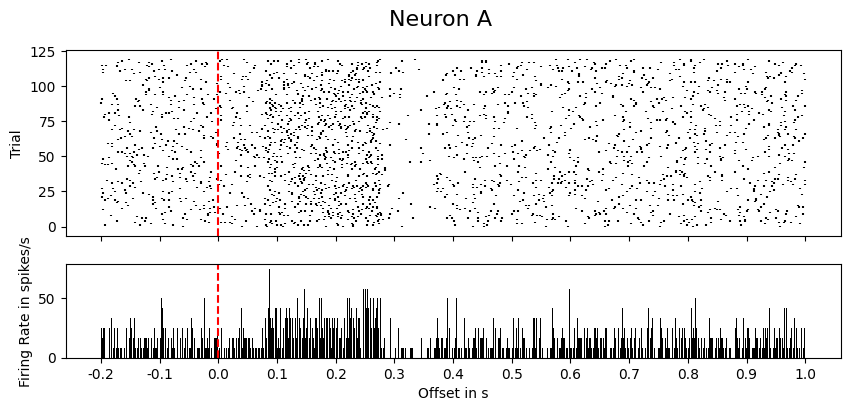

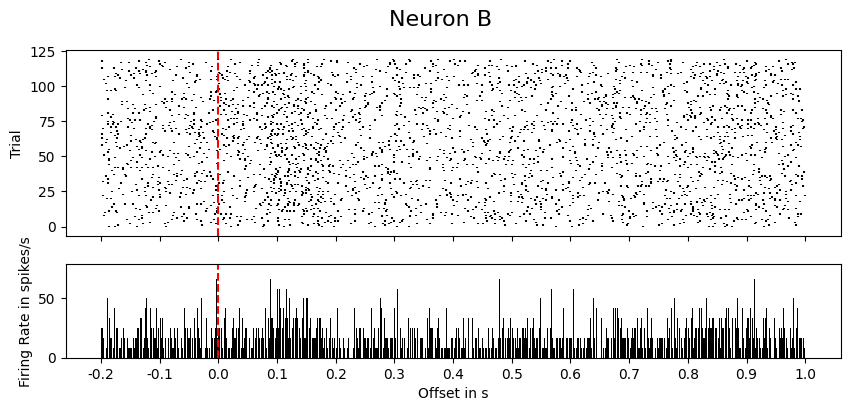

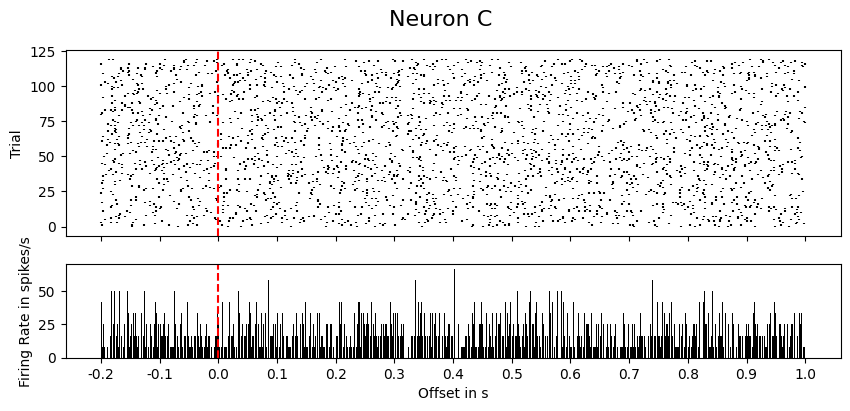

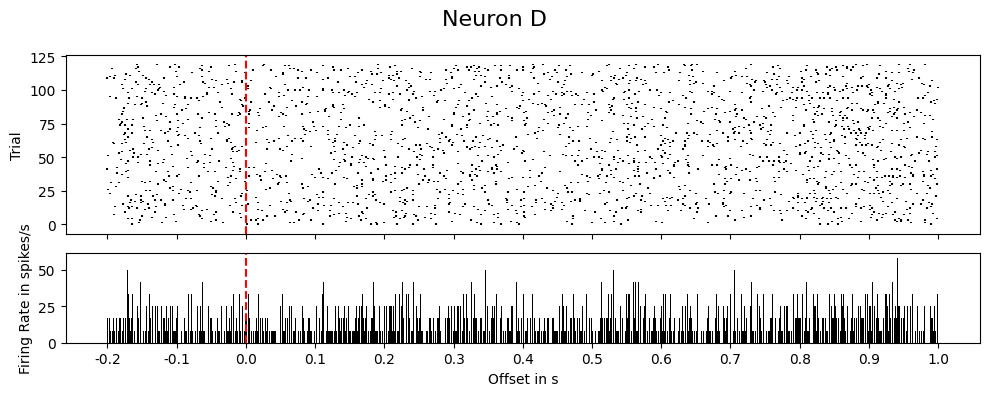

In [23]:
# Visualise raster plot and PSTH for each neuron for window around sound event
for i in range(spike_trains.shape[0]):

    fig, axes = plt.subplots(2, sharex=True, height_ratios=[2, 1])

    plot_raster(spike_arr[i], trial_window, axes[0])
    plot_psth(psth_vals[i], trial_window, axes[1])

    fig.suptitle(f"Neuron {'ABCD'[i]}", fontsize=16)

plt.tight_layout()

## Section B

Based on the figures, there seems to be an increase in firing rate after the sound stimulus for neurons A and B, but not for neurons C and D. In particular, neuron A exhibits an increase in average firing rate from about 15 spikes/s to about 40 spikes/s between 100 and 300 ms after the stimulus onset, followed by a sharp refractory period of about 100 ms. Neuron B shows a similar response, but limited to a window between 100 and 200 ms after the stimulus onset and with a shorter and less evident refractory period. The average firing rate of neurons C and D appeared unchanged upon the stimulus onset, and it continues to fluctuate in a stochastic manner over the entire window. In conclusion, neuron A and to a less extent neuron B experienced an increase in average firing rate after stimulus onset, whereas neurons C and D did not seem to respond to the stimulus and maintained their baseline firing pattern.

## Section C

In [25]:
# Process spike train with window around sound event
trial_window = [-500, 501]
spike_arr, psth_vals = process_spike_trains(spike_trains, lick_times, trial_window)

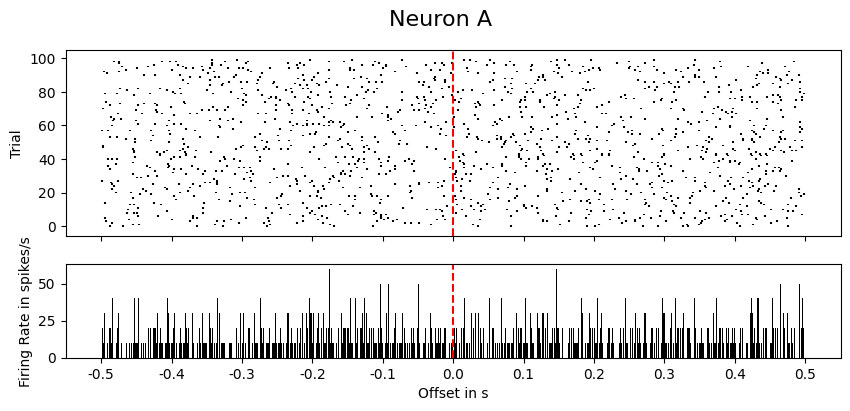

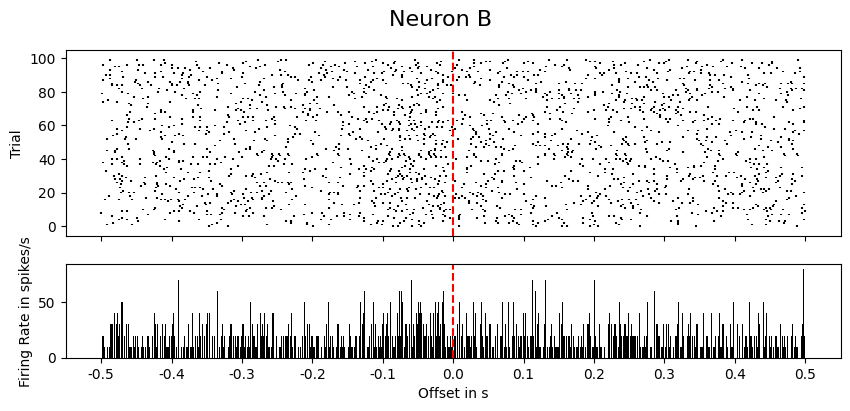

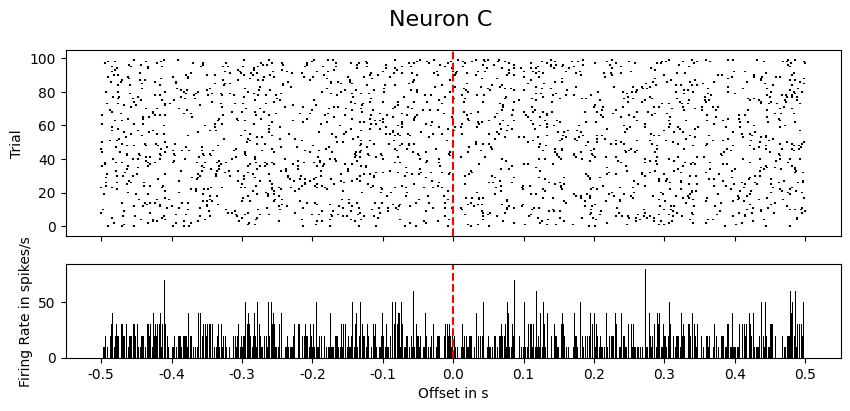

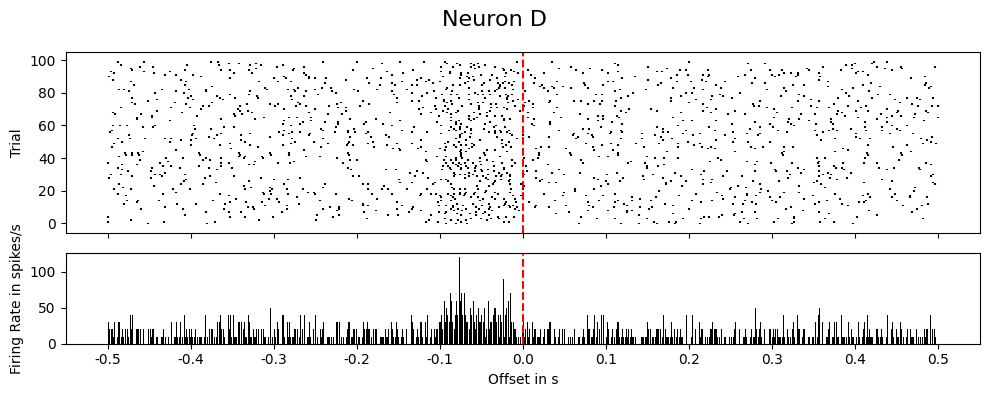

In [28]:
# Visualise raster plot and PSTH for each neuron for window around sound event
for i in range(spike_trains.shape[0]):

    fig, axes = plt.subplots(2, sharex=True, height_ratios=[2, 1])

    plot_raster(spike_arr[i], trial_window, axes[0])
    plot_psth(psth_vals[i], trial_window, axes[1])

    fig.suptitle(f"Neuron {'ABCD'[i]}", fontsize=16)

plt.tight_layout()

Based on the figures above, neurons B and D exhibit an increased firing rate in the 100 ms prior to licking, whereas neurons A and C show a relatively unchanged firing pattern over the entire trial. Remarkably, neurons B and D experience an increase in average firing rate from about 15 spikes/s to about 40 spikes/s only within 100 ms prior to licking. However, their firing pattern seems slightly refracted in the 10 ms prior to licking and ultimately returns to normality during and after licking. Such behaviour may suggest that these two neurons are involved in the intention and planning of licking. In conclusion, neurons B and D, but not neurons A and C show sensitivity to licking in the 100 ms before the action itself.

## Section D

In [3]:
# Import dataset
lick_df = pd.read_csv("PSTH/fr_pre_licks.csv")

In [4]:
# 
lick_df["pred"] = lick_df["fr_100ms_pre"] >= 20
lick_df["pred"] = lick_df["pred"].astype(int)
lick_df["divergence"] = lick_df["lick"] - lick_df["pred"]

In [5]:
def find_accuracy(group):

    accuracy = 1 - np.abs(group["divergence"]).sum() / group["lick"].count()
    return 100 * accuracy

def find_fpr(group):

    false_positives = np.sum(np.where((group["lick"] == 0) & (group["pred"] == 1), 1, 0))
    true_negatives = np.sum(np.where((group["lick"] == 0) & (group["pred"] == 0), 1, 0))

    false_positive_rate = false_positives / (false_positives + true_negatives)
    return 100 * false_positive_rate

def find_tpr(group):

    true_positives = np.sum(np.where((group["lick"] == 1) & (group["pred"] == 1), 1, 0))
    false_negatives = np.sum(np.where((group["lick"] == 1) & (group["pred"] == 0), 1, 0))

    true_positive_rate = true_positives / (true_positives + false_negatives)
    return 100 * true_positive_rate

In [21]:
gr_lick_df = lick_df.groupby("neuron")
acc = gr_lick_df.apply(find_accuracy).to_list()
fpr = gr_lick_df.apply(find_fpr).to_list()
tpr = gr_lick_df.apply(find_tpr).to_list()

tab = {"Neuron": "ABCD", "ACC (%)": acc, "FPR (%)": fpr, "TNR (%)": tpr}

print(tabulate(tab, headers="keys"))

Neuron      ACC (%)    FPR (%)    TNR (%)
--------  ---------  ---------  ---------
A                50          2          2
B                60         80        100
C                48         18         14
D                95          0         90


## Section E

In [70]:
def apply_threshold(threshold, df):

    df["pred"] = df["fr_100ms_pre"] >= threshold
    df["pred"] = df["pred"].astype(int)
    df["divergence"] = df["lick"] - df["pred"]

    gr_df = df.groupby("neuron")
    fpr = gr_df.apply(find_fpr).to_list()
    tpr = gr_df.apply(find_tpr).to_list()

    return fpr, tpr

In [71]:
threshold_list = range(1, 51)
roc_arr = np.vstack(list(map(lambda threshold: apply_threshold(threshold, lick_df), threshold_list)))

fpr_arr = roc_arr[range(0, roc_arr.shape[0], 2) , :]
tpr_arr = roc_arr[range(1, roc_arr.shape[0], 2), :]

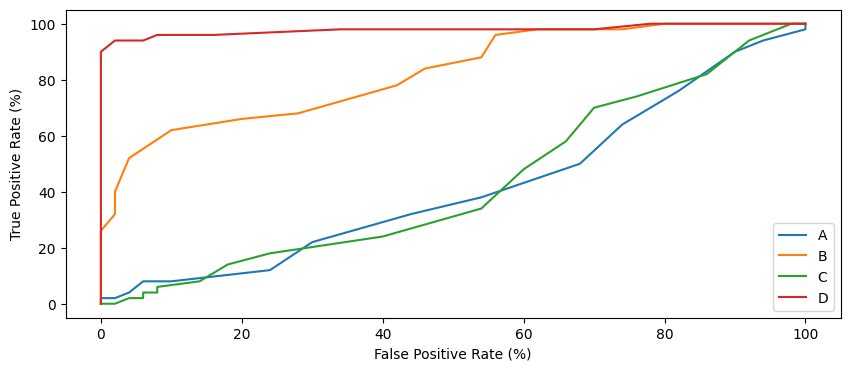

In [72]:
plt.plot(fpr_arr, tpr_arr)

plt.xlabel("False Positive Rate (%)")
plt.ylabel("True Positive Rate (%)")
plt.legend("ABCD")